# Setup

Set run Julia Box parameter (set to true if you run the examples on Julia Box)

In [1]:
run_on_juliabox = true

true

Load packages

In [2]:
using CSV
using PyPlot
using LinearAlgebra
using Distributions
using Statistics
using Printf
using Random
if run_on_juliabox; Pkg.add("KernelDensity"); end 
using KernelDensity;

 Resolving package versions...
  Updating `~/.julia/Project.toml`
 [no changes]
  Updating `~/.julia/Manifest.toml`
 [no changes]


# Bayesian linear regression

Load and plot data

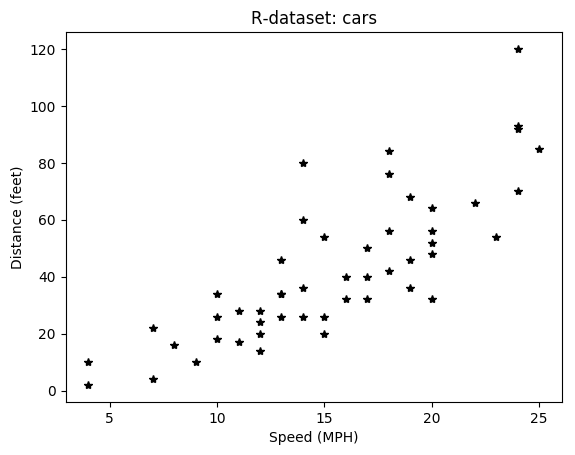

In [3]:
data = CSV.read("cars.csv") # Load the cars stopping distance dataset (see https://stat.ethz.ch/R-manual/R-patched/library/datasets/html/cars.html)
x = convert(Array{Float64,1},data[:,2])
y = convert(Array{Float64,1},data[:,3])

PyPlot.figure()
PyPlot.plot(x,y, "*k")
PyPlot.xlabel("Speed (MPH)")
PyPlot.ylabel("Distance (feet)");
PyPlot.title("R-dataset: cars")
if !run_on_juliabox; PyPlot.savefig("fig/cars_data.svg"); end # dont save plot when running in Julia Box


LS estimations 

In [4]:
n = length(y) # set nbr of obs 

X = ones(n,2) # set design matrix 
X[:,2] = x

# compute LS estimations
β_hat_least_squares = inv(X'*X)*X'*y # est β'as
σ_hat_least_squares = sqrt((y'*y-β_hat_least_squares'*X'*y)/(n-2)) # est σ
β_hat_least_squares_std = σ_hat_least_squares*sqrt.([inv(X'*X)[1,1];inv(X'*X)[2,2]])

# compute conf int for β'as
conf_int_lower_bound = β_hat_least_squares - quantile(TDist(n-2), 0.975)*β_hat_least_squares_std 
conf_int_upper_bound = β_hat_least_squares + quantile(TDist(n-2), 0.975)*β_hat_least_squares_std

# compute conf int for σ (see https://www.overleaf.com/read/bfvqxqhsycgp)
Q_0 = sum((y.-mean(y)).^2) - sum((x.-mean(x)).*(y.-mean(y)))^2/sum((x.-mean(x)).^2)
conf_int_sigma = [sqrt(Q_0/quantile(Chisq(n-2),0.975)); sqrt(Q_0/quantile(Chisq(n-2),0.025))]


# print LS parameter estimations and confidence intervals
@printf "Param. est for β_1: %.2f (%.2f, %.2f)\n" β_hat_least_squares[1] conf_int_lower_bound[1] conf_int_upper_bound[1]
@printf "Param. est for β_2: %.2f (%.2f, %.2f)\n" β_hat_least_squares[2] conf_int_lower_bound[2] conf_int_upper_bound[2]
@printf "Param. est for σ: %.2f (%.2f, %.2f)\n" σ_hat_least_squares conf_int_sigma[1] conf_int_sigma[2]

Param. est for β_1: -17.58 (-31.17, -3.99)
Param. est for β_2: 3.93 (3.10, 4.77)
Param. est for σ: 15.38 (12.83, 19.21)


Specify the Bayesian model

In [5]:
# prior for β's: Normal(0,10)
μ_β_prior = 0;
σ_β_prior = 10;

# prior for σ: Gamma(2,3)
α_σ_prior = 2; # shape parameter
θ_σ_prior = 3; # scale parameter

Prior predictive checks 

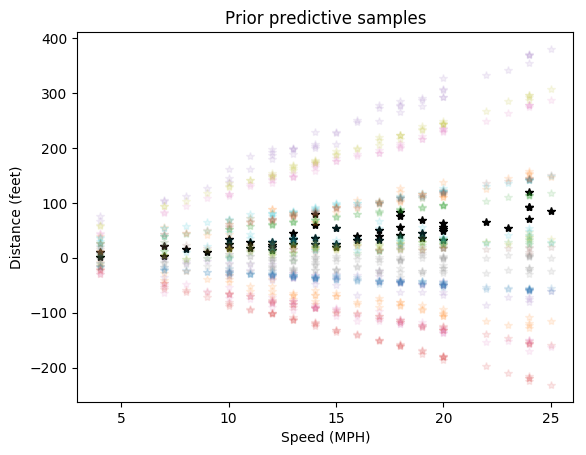

In [6]:
samples = 20
y_prior_pred_samples = zeros(length(x), samples)

Random.seed!(100); # fix random numbers 
β1_prior_pred_samples = rand(Normal(μ_β_prior,σ_β_prior),samples)
β2_prior_pred_samples = rand(Normal(μ_β_prior,σ_β_prior),samples)
σ_prior_pred_samples = rand(Gamma(α_σ_prior, θ_σ_prior), samples)

for i in 1:samples
    y_prior_pred_samples[:,i] = β1_prior_pred_samples[i] .+ x*β2_prior_pred_samples[i] .+ rand(Normal(0,σ_prior_pred_samples[i]), length(x))
end 

PyPlot.figure()
PyPlot.plot(x,y, "*k")
for i in 1:samples
PyPlot.plot(x,  y_prior_pred_samples[:,i], "*", alpha = 0.1)
end 
PyPlot.xlabel("Speed (MPH)")
PyPlot.ylabel("Distance (feet)");
PyPlot.title("Prior predictive samples")
if !run_on_juliabox; PyPlot.savefig("fig/prior_predictions1.svg"); end # dont save plot when running in Julia Box


Set-up functions for sampling from the posterior using the Metropolis-Hastings algorithm

In [7]:
# Evaluates the logarithm of the pdf for the joint prior.
function log_prior(θ::Vector)

  log_β_0_prior = log_normal_pdf(θ[1])
  log_β_1_prior = log_normal_pdf(θ[2])
  log_σ_prior = log_gamma_pdf(θ[3])

  return log_β_0_prior+log_β_1_prior+log_σ_prior

end


# Logarithm of the normal pdf.
log_normal_pdf(x::Real) = -0.5*(x-μ_β_prior)^2/σ_β_prior^2

# Logarithm of the Gamma pdf.
log_gamma_pdf(x::Real) = x <= 0 ? log(0) : (α_σ_prior-1)*log(x)-x/θ_σ_prior


# Log-likelihood for the simple linear model.
function loglik(y::Vector, x::Vector, θ::Vector)

  n = length(y)
  loglik = -n*0.5*log(θ[3]^2)

  for i = 1:n; loglik += -0.5*(y[i]-θ[1]-θ[2]*x[i])^2/θ[3]^2; end

  return loglik

end


# Runs the Metropolis-Hastings algorithm.
function MH(y::Vector, x::Vector, nbr_iter::Int, σ_mh::Vector, θ_0::Vector, print_interval::Int=5000)

  # pre-allocate matrices
  chain = zeros(length(θ_0), nbr_iter)
  loglik_vec = zeros(nbr_iter)
  accept_vec = zeros(nbr_iter)

  # set start values
  chain[:,1] = θ_0
  loglik_vec[1] = loglik(y,x,chain[:,1])

  # print start
  @printf "Starting Metropolis-Hastings\n"



  for i = 2:nbr_iter

    # print info
    if mod(i-1,print_interval) == 0
      # print progress
      @printf "Percentage done: %.2f\n" 100*(i-1)/nbr_iter
      # print current acceptance rate
      @printf "Acceptance rate on iteration %d to %d is %.4f\n" i-print_interval i-1  sum(accept_vec[i-print_interval:i-1])/( i-1 - (i-print_interval) )
    end

    # random walk proposal
    θ_proposal = chain[:,i-1] + rand(Normal(0,1),length(θ_0)).*σ_mh

    # loglik for proposal
    loglik_proposal = loglik(y,x,θ_proposal)

    # compute logarithm of accaptance probability
    α_log = loglik_proposal + log_prior(θ_proposal) - (loglik(y,x,chain[:,i-1])+ log_prior(chain[:,i-1]))

    # generate log random number
    u_log = log(rand())

    # compute accaptance decision
    accept = u_log < α_log

    # update chain
    if accept
      chain[:,i] = θ_proposal
      loglik_vec[i] = loglik_proposal
      accept_vec[i] = 1
    else
      chain[:,i] = chain[:,i-1]
      loglik_vec[i] = loglik_vec[i-1]
    end

  end

  # print info
  @printf "Ending Metropolis-Hastings\n"
  return chain, loglik_vec, accept_vec

end

MH (generic function with 2 methods)

In [8]:
nbr_iter = 50000; # nbr iterations 
burn_in = 10000; # burn-in
scale_proposal = [1.2;0.8;0.5]; # scaling for proposal dist. 
θ_0 = [10,10,10]; # start values 

# fix random numbers 
Random.seed!(100);

chain, loglik_vec, accept_vec = @time MH(y, x, nbr_iter, scale_proposal, θ_0);


Starting Metropolis-Hastings
Percentage done: 10.00
Acceptance rate on iteration 1 to 5000 is 0.1896
Percentage done: 20.00
Acceptance rate on iteration 5001 to 10000 is 0.1940
Percentage done: 30.00
Acceptance rate on iteration 10001 to 15000 is 0.1866
Percentage done: 40.00
Acceptance rate on iteration 15001 to 20000 is 0.1954
Percentage done: 50.00
Acceptance rate on iteration 20001 to 25000 is 0.1860
Percentage done: 60.00
Acceptance rate on iteration 25001 to 30000 is 0.1998
Percentage done: 70.00
Acceptance rate on iteration 30001 to 35000 is 0.1838
Percentage done: 80.00
Acceptance rate on iteration 35001 to 40000 is 0.1966
Percentage done: 90.00
Acceptance rate on iteration 40001 to 45000 is 0.1878
Ending Metropolis-Hastings
  0.464660 seconds (2.71 M allocations: 90.381 MiB, 8.60% gc time)


Plot results

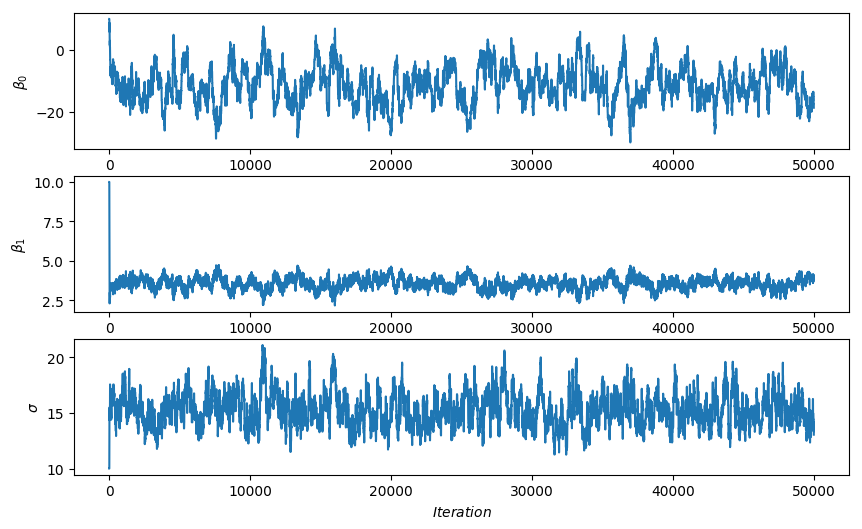

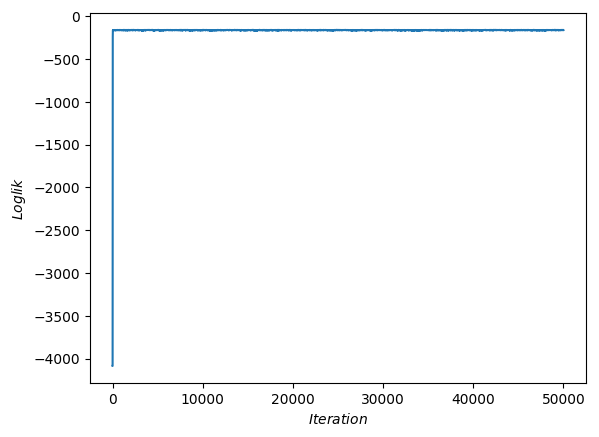

In [9]:
# plot chains
PyPlot.figure(figsize=(10,6));
PyPlot.subplot(311);
PyPlot.plot(chain[1,:]);
PyPlot.ylabel(L"$β_0$");
PyPlot.subplot(312);
PyPlot.plot(chain[2,:]);
PyPlot.ylabel(L"$β_1$");
PyPlot.subplot(313);
PyPlot.plot(chain[3,:]);
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"$σ$");

# plot loglik val at each iteration
PyPlot.figure()
PyPlot.plot(loglik_vec)
PyPlot.xlabel(L"Iteration");
PyPlot.ylabel(L"Loglik");

Posterior predictive samples 

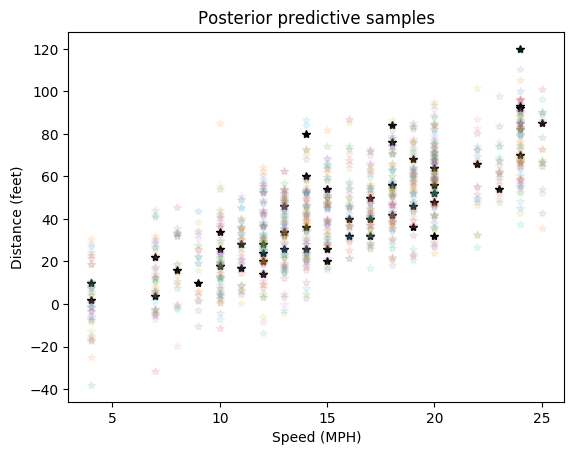

In [10]:
samples = 20
y_post_pred_samples = zeros(length(x), samples)

posterior_idx = rand(burn_in+1:nbr_iter, samples)

Random.seed!(100); # fix random numbers 
β1_post_pred_samples = chain[1,posterior_idx]
β2_post_pred_samples =  chain[2,posterior_idx]
σ_post_pred_samples =  chain[3,posterior_idx]

for i in 1:samples
    y_post_pred_samples[:,i] = β1_post_pred_samples[i] .+ x*β2_post_pred_samples[i] .+ rand(Normal(0,σ_post_pred_samples[i]), length(x))
end 

PyPlot.figure()
PyPlot.plot(x,y, "*k")
for i in 1:samples
PyPlot.plot(x,  y_post_pred_samples[:,i], "*", alpha = 0.1)
end 
PyPlot.xlabel("Speed (MPH)")
PyPlot.ylabel("Distance (feet)");
PyPlot.title("Posterior predictive samples")
if !run_on_juliabox;  PyPlot.savefig("fig/post_predictions.svg"); end # dont save plot when running in Julia Box

Compute posterior means and qunatile intervals.

In [11]:
posterior_samples = chain[:,burn_in:end]

post_mean = mean(posterior_samples,dims=2)

quantile_intervals = [quantile(posterior_samples[1,:], [0.025 0.975]);
                      quantile(posterior_samples[2,:], [0.025 0.975]);
                      quantile(posterior_samples[3,:], [0.025 0.975])]


# print Bayesian parameter estimations and quantile intervals
@printf "Param. est for β_1: %.2f (%.2f, %.2f)\n" post_mean[1] quantile_intervals[1,1] quantile_intervals[1,2]
@printf "Param. est for β_2: %.2f (%.2f, %.2f)\n" post_mean[2] quantile_intervals[2,1] quantile_intervals[2,2]
@printf "Param. est for σ: %.2f (%.2f, %.2f)\n" post_mean[3] quantile_intervals[3,1] quantile_intervals[3,2]

Param. est for β_1: -11.18 (-22.40, 0.99)
Param. est for β_2: 3.56 (2.82, 4.28)
Param. est for σ: 15.23 (12.62, 18.59)


Compaute results for LS and Bayesian approche

In [12]:
# print LS parameter estimations and confidence intervals
@printf "Parameter estimations LS:\n"
@printf "Param. est for β_1: %.2f (%.2f, %.2f)\n" β_hat_least_squares[1] conf_int_lower_bound[1] conf_int_upper_bound[1]
@printf "Param. est for β_2: %.2f (%.2f, %.2f)\n" β_hat_least_squares[2] conf_int_lower_bound[2] conf_int_upper_bound[2]
@printf "Param. est for σ: %.2f (%.2f, %.2f)\n" σ_hat_least_squares conf_int_sigma[1] conf_int_sigma[2]

@printf "\n"

# print Bayesian parameter estimations and quantile intervals
@printf "Parameter estimations Bayesian approche:\n"
@printf "Param. est for β_1: %.2f (%.2f, %.2f)\n" post_mean[1] quantile_intervals[1,1] quantile_intervals[1,2]
@printf "Param. est for β_2: %.2f (%.2f, %.2f)\n" post_mean[2] quantile_intervals[2,1] quantile_intervals[2,2]
@printf "Param. est for σ: %.2f (%.2f, %.2f)\n" post_mean[3] quantile_intervals[3,1] quantile_intervals[3,2]

Parameter estimations LS:
Param. est for β_1: -17.58 (-31.17, -3.99)
Param. est for β_2: 3.93 (3.10, 4.77)
Param. est for σ: 15.38 (12.83, 19.21)

Parameter estimations Bayesian approche:
Param. est for β_1: -11.18 (-22.40, 0.99)
Param. est for β_2: 3.56 (2.82, 4.28)
Param. est for σ: 15.23 (12.62, 18.59)


# Beta-Binomial model 

Set-up model

In [13]:
m = 4; p_true = 0.7; # model parameters 

n = 10; # number of samples from the model 

# data generating function
data_generator(p) = rand(Binomial(m,p),n) 

# generate data
Random.seed!(200) # fix random numbers 
y_obs = data_generator(p_true)

# prior 
α = 2; β = 2
prior = Beta(α,β);

# analytical posterior
posterior = Beta(α + sum(y_obs), β + m*n - sum(y_obs));

# plot function
function plot_abc_inference_results(abc_posterior_samples)
    
    kde_approx_posterior = kde(abc_posterior_samples)

    # plot results
    PyPlot.figure(figsize=(7,4))
    PyPlot.plot(kde_approx_posterior.x,kde_approx_posterior.density, "b")
    PyPlot.plot(0:0.01:1,pdf.(posterior, 0:0.01:1), "r")
    PyPlot.plot(0:0.01:1, pdf.(prior, 0:0.01:1), "g")
    PyPlot.plot((p_true, p_true), (0, maximum(pdf.(posterior, 0:0.01:1))), "k")
    PyPlot.xlabel("p")
    PyPlot.ylabel("Density")
    PyPlot.legend(["ABC posterior"; "Analytical posterior"; "Prior"; "Ground truth"])

end 


plot_abc_inference_results (generic function with 1 method)

ABC algorithm

In [14]:
# ABC rejection sampling algorithm 
function abc_rs(;N_proposals::Int, ϵ::Real, S::Function)
    
    abc_posterior_samples = zeros(N_proposals) 
    nbr_accepted_proposals = 0 
    
    s_obs = S(y_obs) # compute summary statistics for obs. data 
    
    for i in 1:N_proposals
    
        p_star = rand(prior) # sample parameter proposal from prior 
        y_star = data_generator(p_star) # generate data from the computer simulator 
        Δ =  abs(S(y_star)-s_obs) # compute ABC distance      
        
        if Δ <= ϵ # accapte proposal 
            nbr_accepted_proposals += 1 
            abc_posterior_samples[nbr_accepted_proposals] = p_star 
        end 
        
    end 
    
    return abc_posterior_samples[1:nbr_accepted_proposals]
end; 


Run ABC algorithm

In [15]:
# define the summary statistics 
S_handpicked(y) = sum(y); # canonical statistic, i.e. the statistic is sufficient!

# run ABC
Random.seed!(300) # fix random numbers 
abc_posterior_samples = abc_rs(N_proposals = 10^6, ϵ  = 0.1, S=S_handpicked);
@printf "Acceptance rate: %.2f %%" length(abc_posterior_samples)/10^6*100

Acceptance rate: 3.25 %

Plot posterior inference results 

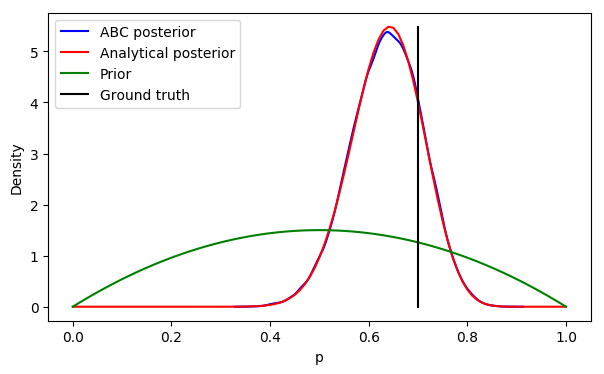

In [16]:
# plot posterior inference results 
plot_abc_inference_results(abc_posterior_samples);